In [72]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import requests

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report



In [27]:
tf.__version__

'2.9.0'

In [28]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [29]:
tf.test.is_gpu_available()

2023-02-23 12:30:12.209779: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-23 12:30:12.209843: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


True

# get data

In [30]:
def get_ds():
    url = "https://datasets-server.huggingface.co/parquet?dataset=aadityaubhat%2FGPT-wiki-intro"
    response = requests.get(url)
    if response.status_code !=200:
        return f"error during dataset request: {response.status_code}"
    
    url_parquet = [files['url'] for files in response.json()['parquet_files']]
    
    
    df = [pd.read_parquet(url_) for url_ in url_parquet]
    
    return pd.concat(df)

In [31]:
os.listdir(path_data)

['data.csv']

In [32]:
path_data = os.path.join(os.path.dirname(os.path.abspath(os.path.curdir)),'raw_data')
if 'data.csv' in os.listdir(path_data):
    print('loading local')
    df = pd.read_csv(path_data+'/data.csv',index_col='id')
else:
    df = get_ds()
    df.set_index('id',inplace=True)
    df['random']=np.random.random(len(df))
    
    # reorganize ds and randomize samples wiki/generated
    df.loc[df['random']<.5,'text']=df['generated_intro']
    df.loc[df['random']<.5,'label']='generated'
    df.loc[df['random']>=.5,'text']=df['wiki_intro']
    df.loc[df['random']>=.5,'label']='wiki'
    df.to_csv('../raw_data/data.csv')
    
df.head()

loading local


,url,title,wiki_intro,generated_intro,title_len,wiki_intro_len,generated_intro_len,prompt,generated_text,prompt_tokens,generated_text_tokens,random,text,label
id,,,,,,,,,,,,,,
63064638,https://en.wikipedia.org/wiki/Sexhow%20railway...,Sexhow railway station,Sexhow railway station was a railway station b...,Sexhow railway station was a railway station l...,3,174,78,200 word wikipedia style introduction on 'Sexh...,"located in the town of Sexhow, on the Cumbria...",25,88,0.170068,Sexhow railway station was a railway station l...,generated
279621,https://en.wikipedia.org/wiki/Eti%C3%A4inen,Etiäinen,"In Finnish folklore, all places and things, an...","In Finnish folklore, all places and things, an...",1,187,80,200 word wikipedia style introduction on 'Etiä...,"animate or inanimate, have a spirit or ""etiäi...",26,101,0.839452,"In Finnish folklore, all places and things, an...",wiki
287229,https://en.wikipedia.org/wiki/Inverse%20functi...,Inverse function theorem,"In mathematics, specifically differential calc...","In mathematics, specifically differential calc...",3,170,59,200 word wikipedia style introduction on 'Inve...,function theorem states that for every real-v...,26,65,0.532203,"In mathematics, specifically differential calc...",wiki
26712375,https://en.wikipedia.org/wiki/Stepping%20on%20...,Stepping on Roses,is a Japanese shōjo manga series written and i...,is a Japanese shōjo manga series written and i...,3,335,121,200 word wikipedia style introduction on 'Step...,and illustrated by Maki Fujii. The series fol...,26,150,0.715507,is a Japanese shōjo manga series written and i...,wiki
38894426,https://en.wikipedia.org/wiki/Rob%20Bradley,Rob Bradley,"Robert Milner ""Rob"" Bradley, Jr. (born August ...","Robert Milner ""Rob"" Bradley, Jr. (born August ...",2,170,136,200 word wikipedia style introduction on 'Rob ...,"29, 1973) is an American former professional ...",28,162,0.395063,"Robert Milner ""Rob"" Bradley, Jr. (born August ...",generated


In [33]:
#check distribution is similar accross classes

In [34]:
df[df['label']=='generated'].describe()

,title_len,wiki_intro_len,generated_intro_len,prompt_tokens,generated_text_tokens,random
count,74978.000000,74978.000000,74978.000000,74978.000000,74978.000000,74978.000000
mean,2.213689,196.078716,129.492865,28.938182,165.734816,0.251266
std,0.627942,41.496280,57.087880,5.056070,77.239233,0.144518
min,1.000000,150.000000,7.000000,21.000000,2.000000,0.000007
25%,2.000000,164.000000,86.000000,26.000000,107.000000,0.125750
50%,2.000000,184.000000,122.000000,28.000000,155.000000,0.251661
75%,3.000000,216.000000,170.000000,31.000000,220.000000,0.376973
max,3.000000,350.000000,278.000000,148.000000,300.000000,0.499997


In [35]:
df[df['label']=='wiki'].describe()

,title_len,wiki_intro_len,generated_intro_len,prompt_tokens,generated_text_tokens,random
count,75022.00000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000
mean,2.21707,195.931553,129.445443,28.977327,165.746688,0.749451
std,0.63108,41.392367,56.993277,5.033946,77.203830,0.144789
min,1.00000,150.000000,7.000000,21.000000,1.000000,0.500001
25%,2.00000,164.000000,86.000000,26.000000,107.000000,0.624155
50%,2.00000,184.000000,122.000000,28.000000,155.000000,0.749220
75%,3.00000,216.000000,170.000000,31.000000,220.000000,0.875147
max,3.00000,350.000000,276.000000,116.000000,300.000000,0.999985


In [36]:
X_train,X_test,y_train,y_test = train_test_split(df['text'],df['label'],test_size=.2)

In [37]:
y_train

id
1469885          wiki
44944148    generated
39308925    generated
31136511    generated
46435501         wiki
              ...    
61569845    generated
58861615         wiki
51499312         wiki
17334432    generated
10064792         wiki
Name: label, Length: 120000, dtype: object

# Baseline

In [38]:
# vectorize text ; using tfidf
vectorize = TfidfVectorizer(ngram_range=(1,1),max_df=.95,min_df=.05)

#transform
X_train_vect = vectorize.fit_transform(X_train)
X_test_vect = vectorize.transform(X_test)

In [39]:
X_train_vect.shape

(120000, 213)

In [40]:
#NB
model = MultinomialNB()
model.fit(X_train_vect,y_train)

MultinomialNB()

In [41]:
# accuracy of NB model
model.score(X_test_vect,y_test)

0.7454

In [42]:
# classification report 
y_pred = model.predict(X_test_vect)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

   generated       0.72      0.76      0.74     14389
        wiki       0.77      0.73      0.75     15611

    accuracy                           0.75     30000
   macro avg       0.75      0.75      0.75     30000
weighted avg       0.75      0.75      0.75     30000



In [47]:
try:
    X_train_vect = X_train_vect.toarray()
    X_test_vect = X_test_vect.toarray()
except AttributeError:
    pass

if len(X_train_vect.shape)<3:
    X_train_vect = np.expand_dims(X_train_vect,-1)
    X_test_vect = np.expand_dims(X_test_vect,-1)

y_train = np.where(y_train=='generated',1,0)
y_test = np.where(y_test=='generated',1,0)

# Features engineering

In [20]:
#WIP

# Models

## Simple LSTM

In [42]:
def lstm_model():
    inputs = tf.keras.layers.Input(shape=(X_train_vect[0].shape))
#     inputs = tf.keras.layers.Input(shape=(200,1))
#     x = tf.keras.layers.LSTM(128,return_sequences=True,activation='tanh')(inputs)
    x = tf.keras.layers.LSTM(32,return_sequences=False,activation='tanh')(inputs)
    x = tf.keras.layers.Dense(16,activation='relu')(x)
    outputs = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    
    return tf.keras.Model(inputs=inputs,outputs=outputs)

In [55]:
#compile
lstm = lstm_model()
lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')

In [62]:
#callbacks

#early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=4,restore_best_weights=True)

#tensorboard
log_dir = os.path.join(os.path.abspath(os.path.pardir),'logs','simple_lstm')
tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir,write_graph=False,)

#learning rate
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=.5,patience=3,verbose=1)

In [ ]:
history = lstm.fit(x=X_train_vect,
                   y=np.expand_dims(y_train,-1),
                   validation_split=.2,
                   callbacks=[es,tb,lr],
                   batch_size=32,
                   epochs=50,)

Epoch 1/50
3000/3000 [==============================] - 167s 56ms/step - loss: 0.5606 - accuracy: 0.7086 - val_loss: 0.5541 - val_accuracy: 0.7103 - lr: 5.0000e-04
Epoch 2/50
3000/3000 [==============================] - 168s 56ms/step - loss: 0.5544 - accuracy: 0.7125 - val_loss: 0.5461 - val_accuracy: 0.7162 - lr: 5.0000e-04
Epoch 3/50
3000/3000 [==============================] - 168s 56ms/step - loss: 0.5470 - accuracy: 0.7179 - val_loss: 0.5421 - val_accuracy: 0.7186 - lr: 5.0000e-04
Epoch 4/50
3000/3000 [==============================] - 168s 56ms/step - loss: 0.5436 - accuracy: 0.7224 - val_loss: 0.5391 - val_accuracy: 0.7205 - lr: 5.0000e-04
Epoch 5/50
3000/3000 [==============================] - 169s 56ms/step - loss: 0.5373 - accuracy: 0.7265 - val_loss: 0.5257 - val_accuracy: 0.7348 - lr: 5.0000e-04
Epoch 6/50
3000/3000 [==============================] - 171s 57ms/step - loss: 0.5345 - accuracy: 0.7293 - val_loss: 0.5228 - val_accuracy: 0.7350 - lr: 5.0000e-04
Epoch 7/50
3000/

In [64]:
lstm.save(os.path.join(os.path.abspath(os.path.pardir),'models','simple_lstm'))

INFO:tensorflow:Assets written to: /Users/arthurcollard/code/arthurcol/gpt_vs_human/models/simple_lstm/assets


INFO:tensorflow:Assets written to: /Users/arthurcollard/code/arthurcol/gpt_vs_human/models/simple_lstm/assets


## Using Bidirectional LSTM

In [48]:
def bilstm_model():
    inputs = tf.keras.layers.Input(shape=(X_train_vect[0].shape))
#     inputs = tf.keras.layers.Input(shape=(200,1))
#     x = tf.keras.layers.LSTM(128,return_sequences=True,activation='tanh')(inputs)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=False,activation='tanh'))(inputs)
    x = tf.keras.layers.Dense(16,activation='relu')(x)
    outputs = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    
    return tf.keras.Model(inputs=inputs,outputs=outputs)

In [57]:
#compile
bilstm = bilstm_model()
bilstm.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')

In [58]:
#callbacks

model_name='bi_lstm_2'

#early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3,restore_best_weights=True)

#tensorboard
log_dir = os.path.join(os.path.abspath(os.path.pardir),'logs',model_name)
tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir,write_graph=False,)

#learning rate
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=.5,patience=2,verbose=1)

#model checkpoint
model_path = os.path.join(os.path.abspath(os.path.pardir),'models',model_name)
mc = tf.keras.callbacks.ModelCheckpoint(filepath=model_path,
                                        monitor='val_accuracy',
                                        verbose=1,
                                        save_best_only=True,
                                        save_weights_only=True)

In [59]:
history = bilstm.fit(x=X_train_vect,
                   y=np.expand_dims(y_train,-1),
                   validation_split=.2,
                   callbacks=[es,tb,lr],
                   batch_size=64,
                   epochs=50,)

Epoch 1/50


2023-02-23 12:43:10.165371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-23 12:43:10.333292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-23 12:43:10.333407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-23 12:43:10.926542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-23 12:43:10.940076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1500/1500 [==============================] - ETA: 0s - loss: 0.6475 - accuracy: 0.6240

2023-02-23 12:45:28.739470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-23 12:45:28.803788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-23 12:45:28.803829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1500/1500 [==============================] - 161s 105ms/step - loss: 0.6475 - accuracy: 0.6240 - val_loss: 0.6132 - val_accuracy: 0.6732 - lr: 0.0010
Epoch 2/50
1500/1500 [==============================] - 157s 105ms/step - loss: 0.6183 - accuracy: 0.6631 - val_loss: 0.6061 - val_accuracy: 0.6758 - lr: 0.0010
Epoch 3/50
1500/1500 [==============================] - 155s 103ms/step - loss: 0.6020 - accuracy: 0.6770 - val_loss: 0.5903 - val_accuracy: 0.6892 - lr: 0.0010
Epoch 4/50
1500/1500 [==============================] - 156s 104ms/step - loss: 0.5899 - accuracy: 0.6893 - val_loss: 0.5965 - val_accuracy: 0.6824 - lr: 0.0010
Epoch 5/50
1500/1500 [==============================] - 158s 105ms/step - loss: 0.5707 - accuracy: 0.7059 - val_loss: 0.5755 - val_accuracy: 0.7003 - lr: 0.0010
Epoch 6/50
1500/1500 [==============================] - 158s 105ms/step - loss: 0.5617 - accuracy: 0.7134 - val_loss: 0.5519 - val_accuracy: 0.7175 - lr: 0.0010
Epoch 7/50
1500/1500 [=======================

## Unleash the power of attention models

In [88]:
from transformers import TFBertModel, BertTokenizerFast

In [65]:
bert = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [89]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [91]:
%%time
lengths = [len(x.split()) for x in X_train]
tokens_raw = tokenizer(list(X_train))

Token indices sequence length is longer than the specified maximum sequence length for this model (563 > 512). Running this sequence through the model will result in indexing errors


CPU times: user 58.3 s, sys: 4.15 s, total: 1min 2s
Wall time: 16.3 s


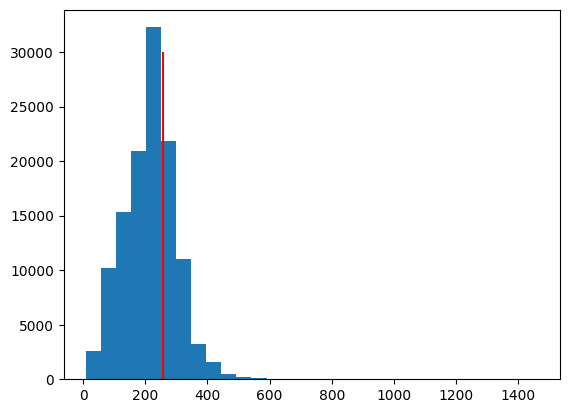

In [114]:
#get lengths
lengths = [len(x) for x in tokens_raw.input_ids]
#check distribution of lengths of tokens
plt.hist(lengths,bins=30);
plt.vlines(x=256,ymin=0,ymax=30000,color='r')

In [129]:
## check proportion
_ = sum(len(el) <= 256 for el in tokens_raw.input_ids)/len(tokens_raw.input_ids)*100

print(f'{_:.2f}% of texts contains less than 256 tokens (not words!)')

69.93% of texts contains less than 256 tokens (not words!)


In [132]:
# tokens with truncation and padding 
tokens_train = tokenizer(list(X_train),padding='max_length',max_length=256,truncation=True)
tokens_test = tokenizer(list(X_test),padding='max_length',max_length=256,truncation=True)

In [188]:
def init_bertmodel():
    input_ids = tf.keras.layers.Input(shape=(256),dtype=tf.int32,name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(256),dtype=tf.int32,name='attention_mask')
    
    backbone = TFBertModel.from_pretrained('bert-base-uncased',)
    pooler_output = backbone(input_ids,attention_mask)['pooler_output']
    backbone.trainable = False
    
    x = tf.keras.layers.Dense(128,activation='relu')(pooler_output)
    output = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=(input_ids,attention_mask),outputs=output)
    
    return model

In [189]:
#compile
bertmodel = init_bertmodel()
bertmodel.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [190]:
#callbacks

model_name='bertmodel'

#early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3,restore_best_weights=True)

#tensorboard
log_dir = os.path.join(os.path.abspath(os.path.pardir),'logs',model_name)
tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir,write_graph=False,)

#learning rate
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=.5,patience=2,verbose=1)

#model checkpoint
model_path = os.path.join(os.path.abspath(os.path.pardir),'models',model_name)
mc = tf.keras.callbacks.ModelCheckpoint(filepath=model_path,
                                        monitor='val_accuracy',
                                        verbose=1,
                                        save_best_only=True,
                                        save_weights_only=True)

In [ ]:
history = bertmodel.fit(x={
    'input_ids':np.array(tokens_train.input_ids),
    'attention_mask':np.array(tokens_train.attention_mask)},
                   y=np.expand_dims(y_train,-1),
                   validation_split=.2,
                   callbacks=[es,tb,lr],
                   batch_size=64,
                   epochs=50,)

Epoch 1/50


2023-02-23 15:56:38.939972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 154/1500 [==>...........................] - ETA: 37:36 - loss: 0.4893 - accuracy: 0.7612